In [1]:
#Import Stuff
import pyart
import scipy
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from datetime import datetime
import os
import seaborn as sns
import xarray as xr
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
### Radar Location
radar_Lat=51.144682
radar_Long=-1.4393
radar_Alt=85.8


### Trap Locations
Porton_Down_Lat=51.1443825
Porton_Down_Long=-1.6826019
Porton_Down_Alt=110
radar_to_Porton_Down_Bearing=269.9822
radar_to_Porton_Down_Distance=16.97*1000

Bentley_Wood_Lat=51.0903015
Bentley_Wood_Long=-1.6401474
Bentley_Wood_Alt=130
radar_to_Bentley_Wood_Bearing=246.7464
radar_to_Bentley_Wood_Distance=15.27*1000


In [3]:
date_str='chilbolton_201710'
write_folder='Oct2017'

In [4]:
data_dir='/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2'

In [5]:
def all_files(data_dir,findstr):
    print(data_dir+'/**/*'+findstr+'*.nc')
    files= glob(data_dir+'/**/*'+findstr+'*.nc', recursive=True)
    files.sort()
    return files

In [6]:
files=all_files(data_dir, date_str)
print(files)


/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/**/*chilbolton_201710*.nc
['/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-000317_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-000957_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-001638_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-002320_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-003002_SUR_v1.nc', '/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_201

In [7]:
radar=pyart.io.read(files[0])

In [8]:
radar.fields.keys()

dict_keys(['RhoHV', 'SNRv', 'ZDR', 'dBZ', 'uKDPu', 'DOP', 'SQIvu', 'PhiDP', 'dBuZ', 'CCOR', 'Vvu', 'Wvu', 'Wv', 'Wu', 'uPhiDP', 'KDP', 'dBZv', 'forecast_temp_qc', 'dBuZv', 'SNRvu', 'RhoHVu', 'CCORv', 'SNRu', 'ZDRu', 'W', 'V', 'u_wind_component', 'temperature', 'SQIv', 'SQIu', 'uPhiDPu', 'rh', 'SQI', 'v_wind_component', 'SNR', 'Vu', 'Vv', 'DOPu', 'uKDP'])

In [9]:
radar=pyart.io.read(files[0])

def find_nearest_7x3(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_7x3=np.squeeze([idx_a-1,idx_a,idx_a+1])
    
    idx_r_7x3=[]
    for i in np.arange(0,len(idx_a_7x3)):
        r=np.sqrt(radar.gate_x['data'][idx_a_7x3[i],:]**2+radar.gate_y['data'][idx_a_7x3[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[1]
        if i==0:
            idx_r_7x3=[[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2],[idx_r+3]]
        else:
            idx_r_7x3=np.append(idx_r_7x3, [[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2],[idx_r+3]],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_7x3]
    Ranges=radar.range['data'][idx_r_7x3]
    X=radar.gate_x['data'][idx_a_7x3, idx_r_7x3]
    Y=radar.gate_y['data'][idx_a_7x3, idx_r_7x3]
    Z=radar.gate_z['data'][idx_a_7x3, idx_r_7x3]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_7x3, idx_r_7x3],0),0)
    return idx_a_7x3, idx_r_7x3, Azis, Ranges,  X, Y, Z,# test


#, idx_r_7x3, radar.gate_y['data'][idx_a_7x3,idx_r_7x3], radar.gate_z['data'][idx_a_7x3,idx_r_7x3],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_7x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_7x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=-20

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=-20

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(np.nanmax(Porton_Down_Ranges,0),0)
df_Porton_Down['Mean_Range']=np.nanmean(np.nanmean(Porton_Down_Ranges,0),0)
df_Porton_Down['Min_Range']=np.nanmin(np.nanmin(Porton_Down_Ranges,0),0)

df_Porton_Down['Max_Azimuth']=np.nanmax(np.nanmax(Porton_Down_Azis,0),0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(np.nanmean(Porton_Down_Azis,0),0)
df_Porton_Down['Min_Azimuth']=np.nanmin(np.nanmin(Porton_Down_Azis,0),0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_X,0),0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_X,0),0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_X,0),0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_Y,0),0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_Y,0),0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_Y,0),0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Porton_Down_Z,0),0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Porton_Down_Z,0),0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Porton_Down_Z,0),0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(np.nanmax(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Mean_Range']=np.nanmean(np.nanmean(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Min_Range']=np.nanmin(np.nanmin(Bentley_Wood_Ranges,0),0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(np.nanmax(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(np.nanmean(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(np.nanmin(Bentley_Wood_Azis,0),0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_X,0),0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_X,0),0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_X,0),0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_Y,0),0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Bentley_Wood_Z,0),0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Porton_Down_Closest_7x3_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Bentley_Wood_Closest_7x3_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_7x3_Metrics.xlsx", sheet_name='Porton_Down_7x3_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_7x3_Metrics.xlsx", sheet_name='Bentley_Wood_7x3_Metrics')



No File To Delete


In [10]:


def find_nearest_4x2(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_4x2=np.squeeze([idx_a,idx_a+1])
    
    idx_r_4x2=[]
    for i in np.arange(0,len(idx_a_4x2)):
        r=np.sqrt(radar.gate_x['data'][idx_a_4x2[i],:]**2+radar.gate_y['data'][idx_a_4x2[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[1]
        if i==0:
            idx_r_4x2=[[idx_r-2],[idx_r-1],[idx_r],[idx_r+1]]
        else:
            idx_r_4x2=np.append(idx_r_4x2, [[idx_r-2],[idx_r-1],[idx_r],[idx_r+1]],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_4x2]
    Ranges=radar.range['data'][idx_r_4x2]
    X=radar.gate_x['data'][idx_a_4x2, idx_r_4x2]
    Y=radar.gate_y['data'][idx_a_4x2, idx_r_4x2]
    Z=radar.gate_z['data'][idx_a_4x2, idx_r_4x2]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_4x2, idx_r_4x2],0),0)
    return idx_a_4x2, idx_r_4x2, Azis, Ranges,  X, Y, Z,# test


#, idx_r_4x2, radar.gate_y['data'][idx_a_4x2,idx_r_4x2], radar.gate_z['data'][idx_a_4x2,idx_r_4x2],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_4x2( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_4x2(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=-10

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=-10

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(np.nanmax(Porton_Down_Ranges,0),0)
df_Porton_Down['Mean_Range']=np.nanmean(np.nanmean(Porton_Down_Ranges,0),0)
df_Porton_Down['Min_Range']=np.nanmin(np.nanmin(Porton_Down_Ranges,0),0)

df_Porton_Down['Max_Azimuth']=np.nanmax(np.nanmax(Porton_Down_Azis,0),0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(np.nanmean(Porton_Down_Azis,0),0)
df_Porton_Down['Min_Azimuth']=np.nanmin(np.nanmin(Porton_Down_Azis,0),0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_X,0),0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_X,0),0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_X,0),0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_Y,0),0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_Y,0),0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_Y,0),0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Porton_Down_Z,0),0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Porton_Down_Z,0),0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Porton_Down_Z,0),0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(np.nanmax(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Mean_Range']=np.nanmean(np.nanmean(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Min_Range']=np.nanmin(np.nanmin(Bentley_Wood_Ranges,0),0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(np.nanmax(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(np.nanmean(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(np.nanmin(Bentley_Wood_Azis,0),0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_X,0),0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_X,0),0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_X,0),0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_Y,0),0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Bentley_Wood_Z,0),0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Porton_Down_Closest_4x2_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Bentley_Wood_Closest_4x2_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_4x2_Metrics.xlsx", sheet_name='Porton_Down_4x2_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_4x2_Metrics.xlsx", sheet_name='Bentley_Wood_4x2_Metrics')



No File To Delete


In [11]:


def find_nearest_6x3(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_6x3=np.squeeze([idx_a-1,idx_a,idx_a+1])
    
    idx_r_6x3=[]
    for i in np.arange(0,len(idx_a_6x3)):
        r=np.sqrt(radar.gate_x['data'][idx_a_6x3[i],:]**2+radar.gate_y['data'][idx_a_6x3[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[1]
        if i==0:
            idx_r_6x3=[[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2]]
        else:
            idx_r_6x3=np.append(idx_r_6x3, [[idx_r-3],[idx_r-2],[idx_r-1],[idx_r],[idx_r+1],[idx_r+2]],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_6x3]
    Ranges=radar.range['data'][idx_r_6x3]
    X=radar.gate_x['data'][idx_a_6x3, idx_r_6x3]
    Y=radar.gate_y['data'][idx_a_6x3, idx_r_6x3]
    Z=radar.gate_z['data'][idx_a_6x3, idx_r_6x3]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_6x3, idx_r_6x3],0),0)
    return idx_a_6x3, idx_r_6x3, Azis, Ranges,  X, Y, Z,# test


#, idx_r_6x3, radar.gate_y['data'][idx_a_6x3,idx_r_6x3], radar.gate_z['data'][idx_a_6x3,idx_r_6x3],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_6x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_6x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=0

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=0

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(np.nanmax(Porton_Down_Ranges,0),0)
df_Porton_Down['Mean_Range']=np.nanmean(np.nanmean(Porton_Down_Ranges,0),0)
df_Porton_Down['Min_Range']=np.nanmin(np.nanmin(Porton_Down_Ranges,0),0)

df_Porton_Down['Max_Azimuth']=np.nanmax(np.nanmax(Porton_Down_Azis,0),0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(np.nanmean(Porton_Down_Azis,0),0)
df_Porton_Down['Min_Azimuth']=np.nanmin(np.nanmin(Porton_Down_Azis,0),0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_X,0),0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_X,0),0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_X,0),0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Porton_Down_Y,0),0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Porton_Down_Y,0),0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Porton_Down_Y,0),0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Porton_Down_Z,0),0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Porton_Down_Z,0),0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Porton_Down_Z,0),0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(np.nanmax(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Mean_Range']=np.nanmean(np.nanmean(Bentley_Wood_Ranges,0),0)
df_Bentley_Wood['Min_Range']=np.nanmin(np.nanmin(Bentley_Wood_Ranges,0),0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(np.nanmax(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(np.nanmean(Bentley_Wood_Azis,0),0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(np.nanmin(Bentley_Wood_Azis,0),0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_X,0),0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_X,0),0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_X,0),0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(np.nanmax(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(np.nanmean(Bentley_Wood_Y,0),0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(np.nanmin(Bentley_Wood_Y,0),0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(np.nanmax(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(np.nanmean(Bentley_Wood_Z,0),0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(np.nanmin(Bentley_Wood_Z,0),0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Porton_Down_Closest_6x3_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Bentley_Wood_Closest_6x3_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_6x3_Metrics.xlsx", sheet_name='Porton_Down_6x3_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_6x3_Metrics.xlsx", sheet_name='Bentley_Wood_6x3_Metrics')



No File To Delete


In [12]:


def find_nearest_2x1(radar,a0,r0, base_alt):
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_2x1=np.squeeze([idx_a,])
    idx_r_2x1=[]
    for i in np.arange(0,len(idx_a_2x1)):
        r=np.sqrt(radar.gate_x['data'][idx_a_2x1[i],:]**2+radar.gate_y['data'][idx_a_2x1[i],:]**2)
        idx_r = np.where((r>r0-75) & (r<r0+75))[0].astype('int')

        if i==0:
            idx_r_2x1=[idx_r-1,idx_r]
        else:
            idx_r_2x1=np.append(idx_r_2x1, [idx_r-1,idx_r],axis=1)
    
    Azis=radar.azimuth['data'][idx_a_2x1]
    Ranges=radar.range['data'][idx_r_2x1]
    X=radar.gate_x['data'][idx_a_2x1, idx_r_2x1]
    Y=radar.gate_y['data'][idx_a_2x1, idx_r_2x1]
    Z=radar.gate_z['data'][idx_a_2x1, idx_r_2x1]+radar.altitude['data'].data[0]-base_alt
    #test=np.nanmean(np.nanmean(radar.fields['dBZ']['data'][idx_a_2x1, idx_r_2x1],0),0)
    return idx_a_2x1, idx_r_2x1, Azis, Ranges,  X, Y, Z,# test


#, idx_r_2x1, radar.gate_y['data'][idx_a_2x1,idx_r_2x1], radar.gate_z['data'][idx_a_2x1,idx_r_2x1],


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z = find_nearest_2x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_2x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)


radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=10

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=10

#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=np.nanmax(Porton_Down_Ranges,0)
df_Porton_Down['Mean_Range']=np.nanmean(Porton_Down_Ranges,0)
df_Porton_Down['Min_Range']=np.nanmin(Porton_Down_Ranges,0)

df_Porton_Down['Max_Azimuth']=np.nanmax(Porton_Down_Azis,0)
df_Porton_Down['Mean_Azimuth']=np.nanmean(Porton_Down_Azis,0)
df_Porton_Down['Min_Azimuth']=np.nanmin(Porton_Down_Azis,0)

df_Porton_Down['Max_X_Distance_from_Radar']=np.nanmax(Porton_Down_X,0)
df_Porton_Down['Mean_X_Distance_from_Radar']=np.nanmean(Porton_Down_X,0)
df_Porton_Down['Min_X_Distance_from_Radar']=np.nanmin(Porton_Down_X,0)

df_Porton_Down['Max_Y_Distance_from_Radar']=np.nanmax(Porton_Down_Y,0)
df_Porton_Down['Mean_Y_Distance_from_Radar']=np.nanmean(Porton_Down_Y,0)
df_Porton_Down['Min_Y_Distance_from_Radar']=np.nanmin(Porton_Down_Y,0)

df_Porton_Down['Max_Altitude_Above_Ground']=np.nanmax(Porton_Down_Z,0)
df_Porton_Down['Mean_Altitude_Above_Ground']=np.nanmean(Porton_Down_Z,0)
df_Porton_Down['Min_Altitude_Above_Ground']=np.nanmin(Porton_Down_Z,0)


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=np.nanmax(Bentley_Wood_Ranges,0)
df_Bentley_Wood['Mean_Range']=np.nanmean(Bentley_Wood_Ranges,0)
df_Bentley_Wood['Min_Range']=np.nanmin(Bentley_Wood_Ranges,0)

df_Bentley_Wood['Max_Azimuth']=np.nanmax(Bentley_Wood_Azis,0)
df_Bentley_Wood['Mean_Azimuth']=np.nanmean(Bentley_Wood_Azis,0)
df_Bentley_Wood['Min_Azimuth']=np.nanmin(Bentley_Wood_Azis,0)

df_Bentley_Wood['Max_X_Distance_from_Radar']=np.nanmax(Bentley_Wood_X,0)
df_Bentley_Wood['Mean_X_Distance_from_Radar']=np.nanmean(Bentley_Wood_X,0)
df_Bentley_Wood['Min_X_Distance_from_Radar']=np.nanmin(Bentley_Wood_X,0)

df_Bentley_Wood['Max_Y_Distance_from_Radar']=np.nanmax(Bentley_Wood_Y,0)
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=np.nanmean(Bentley_Wood_Y,0)
df_Bentley_Wood['Min_Y_Distance_from_Radar']=np.nanmin(Bentley_Wood_Y,0)

df_Bentley_Wood['Max_Altitude_Above_Ground']=np.nanmax(Bentley_Wood_Z,0)
df_Bentley_Wood['Mean_Altitude_Above_Ground']=np.nanmean(Bentley_Wood_Z,0)
df_Bentley_Wood['Min_Altitude_Above_Ground']=np.nanmin(Bentley_Wood_Z,0)



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Porton_Down_Closest_2x1_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Bentley_Wood_Closest_2x1_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_2x1_Metrics.xlsx", sheet_name='Porton_Down_2x1_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_2x1_Metrics.xlsx", sheet_name='Bentley_Wood_2x1_Metrics')



No File To Delete


In [13]:


def find_nearest_1x1(radar,a0,r0, base_alt):
    idx_a_1x1=[]
    idx_r_1x1=[]
    idx_a = np.squeeze(np.where((radar.azimuth['data'][:]>a0-0.5) &  (radar.azimuth['data'][:]<a0+0.5))[0])
    idx_a_1x1=np.squeeze([idx_a,])
    

    r=np.sqrt(radar.gate_x['data'][idx_a_1x1[:],:]**2+radar.gate_y['data'][idx_a_1x1[:],:]**2)
    idx_r_1x1 = np.where((r>r0-75) & (r<r0+75))[1]

    Azis=radar.azimuth['data'][idx_a_1x1]
    Ranges=radar.range['data'][idx_r_1x1]
    X=radar.gate_x['data'][idx_a_1x1, idx_r_1x1]
    Y=radar.gate_y['data'][idx_a_1x1, idx_r_1x1]
    Z=radar.gate_z['data'][idx_a_1x1, idx_r_1x1]+radar.altitude['data'].data[0]-base_alt
    #test=radar.fields['dBZ']['data'][idx_a_1x1, idx_r_1x1]
    return idx_a_1x1, idx_r_1x1, Azis, Ranges,  X, Y, Z#, test


Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx, Porton_Down_Azis, Porton_Down_Ranges, Porton_Down_X, Porton_Down_Y, Porton_Down_Z= find_nearest_1x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx, Bentley_Wood_Azis, Bentley_Wood_Ranges, Bentley_Wood_X, Bentley_Wood_Y, Bentley_Wood_Z = find_nearest_1x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)

radar.fields['dBZ']['data'][Porton_Down_Azis_Idx,Porton_Down_Ranges_Idx]=20

radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx,Bentley_Wood_Ranges_Idx]=20



#Write Out Pixel Metrics
df_Porton_Down = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Porton_Down['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Porton_Down['Max_Range']=Porton_Down_Ranges
df_Porton_Down['Mean_Range']=Porton_Down_Ranges
df_Porton_Down['Min_Range']=Porton_Down_Ranges

df_Porton_Down['Max_Azimuth']=Porton_Down_Azis
df_Porton_Down['Mean_Azimuth']=Porton_Down_Azis
df_Porton_Down['Min_Azimuth']=Porton_Down_Azis

df_Porton_Down['Max_X_Distance_from_Radar']=Porton_Down_X
df_Porton_Down['Mean_X_Distance_from_Radar']=Porton_Down_X
df_Porton_Down['Min_X_Distance_from_Radar']=Porton_Down_X

df_Porton_Down['Max_Y_Distance_from_Radar']=Porton_Down_Y
df_Porton_Down['Mean_Y_Distance_from_Radar']=Porton_Down_Y
df_Porton_Down['Min_Y_Distance_from_Radar']=Porton_Down_Y

df_Porton_Down['Max_Altitude_Above_Ground']=Porton_Down_Z
df_Porton_Down['Mean_Altitude_Above_Ground']=Porton_Down_Z
df_Porton_Down['Min_Altitude_Above_Ground']=Porton_Down_Z


df_Bentley_Wood = pd.DataFrame(columns=['Scan_Elevation_degrees'])
df_Bentley_Wood['Scan_Elevation_degrees']=radar.fixed_angle['data']

df_Bentley_Wood['Max_Range']=Bentley_Wood_Ranges
df_Bentley_Wood['Mean_Range']=Bentley_Wood_Ranges
df_Bentley_Wood['Min_Range']=Bentley_Wood_Ranges

df_Bentley_Wood['Max_Azimuth']=Bentley_Wood_Azis
df_Bentley_Wood['Mean_Azimuth']=Bentley_Wood_Azis
df_Bentley_Wood['Min_Azimuth']=Bentley_Wood_Azis

df_Bentley_Wood['Max_X_Distance_from_Radar']=Bentley_Wood_X
df_Bentley_Wood['Mean_X_Distance_from_Radar']=Bentley_Wood_X
df_Bentley_Wood['Min_X_Distance_from_Radar']=Bentley_Wood_X

df_Bentley_Wood['Max_Y_Distance_from_Radar']=Bentley_Wood_Y
df_Bentley_Wood['Mean_Y_Distance_from_Radar']=Bentley_Wood_Y
df_Bentley_Wood['Min_Y_Distance_from_Radar']=Bentley_Wood_Y

df_Bentley_Wood['Max_Altitude_Above_Ground']=Bentley_Wood_Z
df_Bentley_Wood['Mean_Altitude_Above_Ground']=Bentley_Wood_Z
df_Bentley_Wood['Min_Altitude_Above_Ground']=Bentley_Wood_Z



try:
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Porton_Down_Closest_1x1_Metrics.xlsx')
    os.remove('/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder+'/Bentley_Wood_Closest_1x1_Metrics.xlsx')

except:
    print('No File To Delete')
    
df_Porton_DownT=df_Porton_Down.T  
df_Bentley_WoodT=df_Bentley_Wood.T

df_Porton_DownT.to_excel("Porton_Down_Closest_1x1_Metrics.xlsx", sheet_name='Porton_Down_1x1_Metrics')
df_Bentley_WoodT.to_excel("Bentley_Wood_Closest_1x1_Metrics.xlsx", sheet_name='Bentley_Wood_1x1_Metrics')



No File To Delete


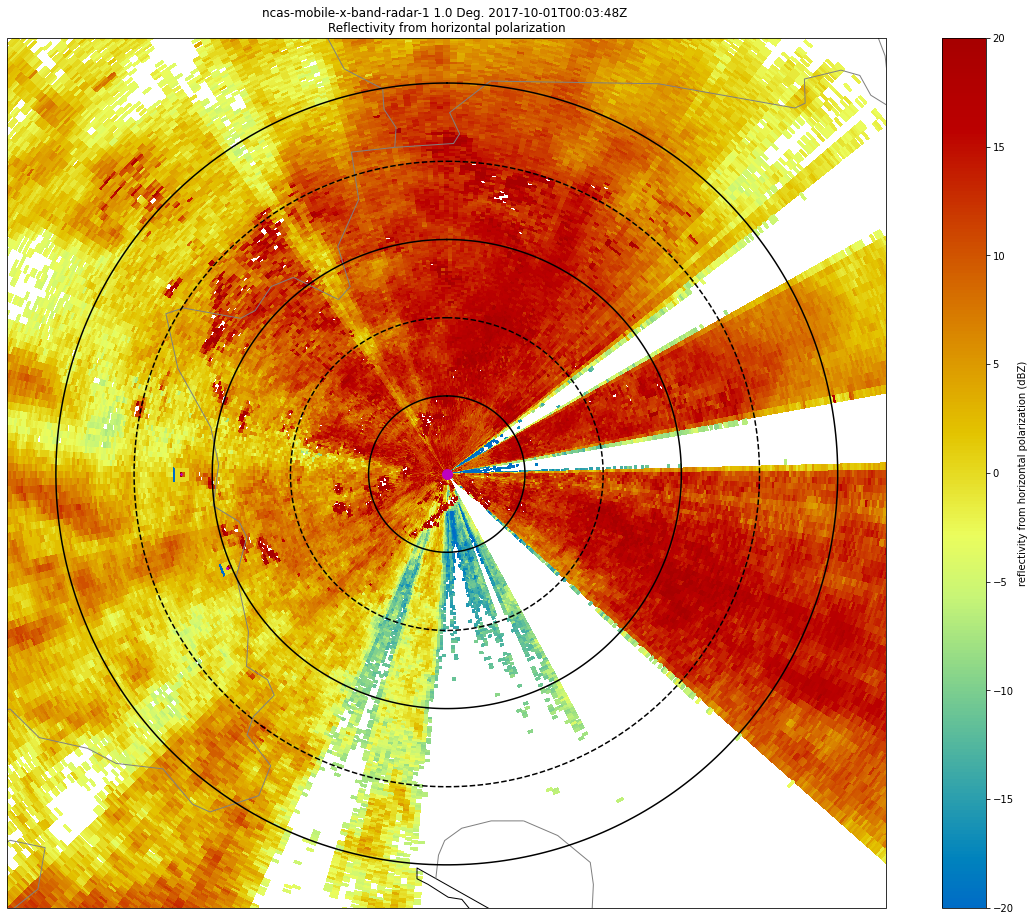

In [14]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = (20,16))
fig.patch.set_facecolor('white')

# Setting projection and ploting the second tilt
projection = ccrs.LambertConformal(central_latitude=radar.latitude['data'][0],
                                   central_longitude=radar.longitude['data'][0])




display.plot_ppi_map('dBZ',1 , vmin=-20, vmax=20, resolution='10m', projection=projection,
                     min_lon=radar.longitude['data'][0]-0.4, max_lon=radar.longitude['data'][0]+0.4, 
                     min_lat=radar.latitude['data'][0]-0.25, max_lat=radar.latitude['data'][0]+0.25,
                     fig=fig, lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0],cmap='pyart_HomeyerRainbow')

# Plot range rings at 10, 20, 30, 40km
display.plot_range_ring(5., line_style='k-')
display.plot_range_ring(10., line_style='k--')
display.plot_range_ring(15., line_style='k-')
display.plot_range_ring(20., line_style='k--')
display.plot_range_ring(25., line_style='k-')

# Plot cross hairs

# Indicate the radar location with a point
display.plot_point(radar.longitude['data'][0], radar.latitude['data'][0],symbol='mo',markersize=10)

display.plot_point(Porton_Down_Long, Porton_Down_Lat,symbol='m*',markersize=2)

display.plot_point(Bentley_Wood_Long, Bentley_Wood_Lat,symbol='mh',markersize=2)


In [ ]:
#Extract data and put in dataframe
Porton_Down={}
Bentley_Wood={}
Porton_Down_2x1={}
Bentley_Wood_2x1={}
Porton_Down_4x2={}
Bentley_Wood_4x2={}
Porton_Down_6x3={}
Bentley_Wood_6x3={}
Porton_Down_7x3={}
Bentley_Wood_7x3={}


fields=['RhoHV', 'SNRv', 'ZDR', 'dBZ', 'uKDPu', 'PhiDP', 'dBuZ', 'uPhiDP', 'KDP', 'dBZv', 'dBuZv', 'SNRvu', 'RhoHVu', 'SNRu', 'ZDRu', 'u_wind_component', 'temperature', 'uPhiDPu', 'rh', 'v_wind_component', 'SNR', 'uKDP']

for v in fields:
    Porton_Down["{0}".format(v)] = np.array([])
    Bentley_Wood["{0}".format(v)] = np.array([])
    Porton_Down_7x3["{0}".format(v)] = np.array([])
    Bentley_Wood_7x3["{0}".format(v)] = np.array([])
    
files=all_files(data_dir,date_str)
print(len(files))
print(files[0])
print(files[-1])    
for idx, f in enumerate(files[:]):
    print(f)
    radar=pyart.io.read(f)
    
    Porton_Down_Azis_Idx_1x1,Porton_Down_Ranges_Idx_1x1, Porton_Down_Azis_1x1, Porton_Down_Ranges_1x1, Porton_Down_X_1x1, Porton_Down_Y_1x1, Porton_Down_Z_1x1 =find_nearest_1x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_1x1,Bentley_Wood_Ranges_Idx_1x1, Bentley_Wood_Azis_1x1, Bentley_Wood_Ranges_1x1, Bentley_Wood_X_1x1, Bentley_Wood_Y_1x1, Bentley_Wood_Z_1x1 =find_nearest_1x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_2x1,Porton_Down_Ranges_Idx_2x1, Porton_Down_Azis_2x1, Porton_Down_Ranges_2x1, Porton_Down_X_2x1, Porton_Down_Y_2x1, Porton_Down_Z_2x1 =find_nearest_2x1( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_2x1,Bentley_Wood_Ranges_Idx_2x1, Bentley_Wood_Azis_2x1, Bentley_Wood_Ranges_2x1, Bentley_Wood_X_2x1, Bentley_Wood_Y_2x1, Bentley_Wood_Z_2x1 =find_nearest_2x1(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_4x2,Porton_Down_Ranges_Idx_4x2, Porton_Down_Azis_4x2, Porton_Down_Ranges_4x2, Porton_Down_X_4x2, Porton_Down_Y_4x2, Porton_Down_Z_4x2 =find_nearest_4x2( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_4x2,Bentley_Wood_Ranges_Idx_4x2, Bentley_Wood_Azis_4x2, Bentley_Wood_Ranges_4x2, Bentley_Wood_X_4x2, Bentley_Wood_Y_4x2, Bentley_Wood_Z_4x2 =find_nearest_4x2(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_6x3,Porton_Down_Ranges_Idx_6x3, Porton_Down_Azis_6x3, Porton_Down_Ranges_6x3, Porton_Down_X_6x3, Porton_Down_Y_6x3, Porton_Down_Z_6x3 =find_nearest_6x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_6x3,Bentley_Wood_Ranges_Idx_6x3, Bentley_Wood_Azis_6x3, Bentley_Wood_Ranges_6x3, Bentley_Wood_X_6x3, Bentley_Wood_Y_6x3, Bentley_Wood_Z_6x3 =find_nearest_6x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)
    
    Porton_Down_Azis_Idx_7x3,Porton_Down_Ranges_Idx_7x3, Porton_Down_Azis_7x3, Porton_Down_Ranges_7x3, Porton_Down_X_7x3, Porton_Down_Y_7x3, Porton_Down_Z_7x3  =find_nearest_7x3( radar,radar_to_Porton_Down_Bearing,radar_to_Porton_Down_Distance,Porton_Down_Alt)
    Bentley_Wood_Azis_Idx_7x3,Bentley_Wood_Ranges_Idx_7x3, Bentley_Wood_Azis_7x3, Bentley_Wood_Ranges_7x3, Bentley_Wood_X_7x3, Bentley_Wood_Y_7x3, Bentley_Wood_Z_7x3 =find_nearest_7x3(radar,radar_to_Bentley_Wood_Bearing, radar_to_Bentley_Wood_Distance,Bentley_Wood_Alt)

    
    for k in Porton_Down.keys():
        try:
            Porton_Down_k_2x1=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_2x1,Porton_Down_Ranges_Idx_2x1].data,0))]
            Bentley_Wood_k_2x1=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_2x1,Bentley_Wood_Ranges_Idx_2x1].data,0))]
        
            Porton_Down_k_4x2=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_4x2,Porton_Down_Ranges_Idx_4x2].data,0),0))]
            Bentley_Wood_k_4x2=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_4x2,Bentley_Wood_Ranges_Idx_4x2].data,0),0))]
        
            Porton_Down_k_6x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_6x3,Porton_Down_Ranges_Idx_6x3].data,0),0))]
            Bentley_Wood_k_6x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_6x3,Bentley_Wood_Ranges_Idx_6x3].data,0),0))]
        
            Porton_Down_k_7x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Porton_Down_Azis_Idx_7x3,Porton_Down_Ranges_Idx_7x3].data,0),0))]
            Bentley_Wood_k_7x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields[k]['data'][Bentley_Wood_Azis_Idx_7x3,Bentley_Wood_Ranges_Idx_7x3].data,0),0))]

            if idx==0:
                Porton_Down[k]=[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Porton_Down_Azis_Idx_1x1,Porton_Down_Ranges_Idx_1x1].data]))]
                Bentley_Wood[k]=[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Bentley_Wood_Azis_Idx_1x1,Bentley_Wood_Ranges_Idx_1x1].data]))]
            
                Porton_Down_2x1[k]=Porton_Down_k_2x1
                Bentley_Wood_2x1[k]=Bentley_Wood_k_2x1
            
                Porton_Down_4x2[k]=Porton_Down_k_4x2
                Bentley_Wood_4x2[k]=Bentley_Wood_k_4x2
            
                Porton_Down_6x3[k]=Porton_Down_k_6x3
                Bentley_Wood_6x3[k]=Bentley_Wood_k_6x3
            
                Porton_Down_7x3[k]=Porton_Down_k_7x3
                Bentley_Wood_7x3[k]=Bentley_Wood_k_7x3
            else:
                Porton_Down[k]=np.append(Porton_Down[k],[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Porton_Down_Azis_Idx[:],Porton_Down_Ranges_Idx].data]))],0)
                Bentley_Wood[k]=np.append(Bentley_Wood[k],[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields[k]['data'][Bentley_Wood_Azis_Idx[:],Bentley_Wood_Ranges_Idx].data]))],0)
            
                Porton_Down_2x1[k]=np.append(Porton_Down_2x1[k],Porton_Down_k_2x1,0)
                Bentley_Wood_2x1[k]=np.append(Bentley_Wood_2x1[k],Bentley_Wood_k_2x1,0)
            
                Porton_Down_4x2[k]=np.append(Porton_Down_4x2[k],Porton_Down_k_4x2,0)
                Bentley_Wood_4x2[k]=np.append(Bentley_Wood_4x2[k],Bentley_Wood_k_4x2,0)
            
                Porton_Down_6x3[k]=np.append(Porton_Down_6x3[k],Porton_Down_k_6x3,0)
                Bentley_Wood_6x3[k]=np.append(Bentley_Wood_6x3[k],Bentley_Wood_k_6x3,0)
            
                Porton_Down_7x3[k]=np.append(Porton_Down_7x3[k],Porton_Down_k_7x3,0)
                Bentley_Wood_7x3[k]=np.append(Bentley_Wood_7x3[k],Bentley_Wood_k_7x3,0)
        
        ####
        except:
            print(k + ' is missing.')
            Porton_Down_k_2x1=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(radar.fields['dBZ']['data'][Porton_Down_Azis_Idx_2x1,Porton_Down_Ranges_Idx_2x1].data,0)*0-9E+33)]
            Bentley_Wood_k_2x1=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx_2x1,Bentley_Wood_Ranges_Idx_2x1].data*0-9E+33,0))]
        
            Porton_Down_k_4x2=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields['dBZ']['data'][Porton_Down_Azis_Idx_4x2,Porton_Down_Ranges_Idx_4x2].data,0),0)*0-9E+33)]
            Bentley_Wood_k_4x2=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx_4x2,Bentley_Wood_Ranges_Idx_4x2].data,0),0)*0-9E+33)]
        
            Porton_Down_k_6x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields['dBZ']['data'][Porton_Down_Azis_Idx_6x3,Porton_Down_Ranges_Idx_6x3].data,0),0)*0-9E+33)]
            Bentley_Wood_k_6x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx_6x3,Bentley_Wood_Ranges_Idx_6x3].data,0),0)*0-9E+33)]
        
            Porton_Down_k_7x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields['dBZ']['data'][Porton_Down_Azis_Idx_7x3,Porton_Down_Ranges_Idx_7x3].data,0),0)*0-9E+33)]
            Bentley_Wood_k_7x3=[np.append(pyart.util.datetime_from_radar(radar),np.nanmean(np.nanmean(radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx_7x3,Bentley_Wood_Ranges_Idx_7x3].data,0),0)*0-9E+33)]

            if idx==0:
                Porton_Down[k]=[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields['dBZ']['data'][Porton_Down_Azis_Idx_1x1,Porton_Down_Ranges_Idx_1x1].data])*0-9E+33)]
                Bentley_Wood[k]=[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx_1x1,Bentley_Wood_Ranges_Idx_1x1].data])*0-9E+33)]
            
                Porton_Down_2x1[k]=Porton_Down_k_2x1
                Bentley_Wood_2x1[k]=Bentley_Wood_k_2x1
            
                Porton_Down_4x2[k]=Porton_Down_k_4x2
                Bentley_Wood_4x2[k]=Bentley_Wood_k_4x2
            
                Porton_Down_6x3[k]=Porton_Down_k_6x3
                Bentley_Wood_6x3[k]=Bentley_Wood_k_6x3
            
                Porton_Down_7x3[k]=Porton_Down_k_7x3
                Bentley_Wood_7x3[k]=Bentley_Wood_k_7x3
            else:
                Porton_Down[k]=np.append(Porton_Down[k],[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields['dBZ']['data'][Porton_Down_Azis_Idx[:],Porton_Down_Ranges_Idx].data])*0-9E+33)],0)
                Bentley_Wood[k]=np.append(Bentley_Wood[k],[np.append(pyart.util.datetime_from_radar(radar),np.squeeze([radar.fields['dBZ']['data'][Bentley_Wood_Azis_Idx[:],Bentley_Wood_Ranges_Idx].data])*0-9E+33)],0)
            
                Porton_Down_2x1[k]=np.append(Porton_Down_2x1[k],Porton_Down_k_2x1,0)
                Bentley_Wood_2x1[k]=np.append(Bentley_Wood_2x1[k],Bentley_Wood_k_2x1,0)
            
                Porton_Down_4x2[k]=np.append(Porton_Down_4x2[k],Porton_Down_k_4x2,0)
                Bentley_Wood_4x2[k]=np.append(Bentley_Wood_4x2[k],Bentley_Wood_k_4x2,0)
            
                Porton_Down_6x3[k]=np.append(Porton_Down_6x3[k],Porton_Down_k_6x3,0)
                Bentley_Wood_6x3[k]=np.append(Bentley_Wood_6x3[k],Bentley_Wood_k_6x3,0)
            
                Porton_Down_7x3[k]=np.append(Porton_Down_7x3[k],Porton_Down_k_7x3,0)
                Bentley_Wood_7x3[k]=np.append(Bentley_Wood_7x3[k],Bentley_Wood_k_7x3,0)
        
        
            
    del radar

#Write dictionary to dataframes and output into excel
radar=pyart.io.read(f)

Porton_Down_Vars=[]
Bentley_Wood_Vars=[]

Porton_Down_Vars_2x1=[]
Bentley_Wood_Vars_2x1=[]

Porton_Down_Vars_4x2=[]
Bentley_Wood_Vars_4x2=[]

Porton_Down_Vars_6x3=[]
Bentley_Wood_Vars_6x3=[]

Porton_Down_Vars_7x3=[]
Bentley_Wood_Vars_7x3=[]
wpath='/gws/smf/j04/ncas_radar/rrniii/BioDAR/notebooks/'+write_folder

try:
    os.remove(wpath + '/Porton_Down_Closest_1x1.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_1x1.xlsx')

    os.remove(wpath + '/Porton_Down_Closest_2x1.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_2x1.xlsx')
    
    os.remove(wpath + '/Porton_Down_Closest_4x2.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_4x2.xlsx')
    
    os.remove(wpath + '/Porton_Down_Closest_6x3.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_6x3.xlsx')
    
    os.remove(wpath + '/Porton_Down_Closest_7x3.xlsx')
    os.remove(wpath + '/Bentley_Wood_Closest_7x3.xlsx')
except:
    print('No File')

for kidx, k in enumerate(Porton_Down.keys()):
  
    Porton_Down_Vars=np.append(Porton_Down_Vars,'Porton_Down_'+str(k))
    Bentley_Wood_Vars=np.append(Bentley_Wood_Vars,'Bentley_Wood_'+str(k))
    
    Porton_Down_Vars_2x1=np.append(Porton_Down_Vars_2x1,'Porton_Down_2x1_'+str(k))
    Bentley_Wood_Vars_2x1=np.append(Bentley_Wood_Vars_2x1,'Bentley_Wood_2x1_'+str(k))
    
    Porton_Down_Vars_4x2=np.append(Porton_Down_Vars_4x2,'Porton_Down_4x2_'+str(k))
    Bentley_Wood_Vars_4x2=np.append(Bentley_Wood_Vars_4x2,'Bentley_Wood_4x2_'+str(k))
    
    Porton_Down_Vars_7x3=np.append(Porton_Down_Vars_6x3,'Porton_Down_6x3_'+str(k))
    Bentley_Wood_Vars_7x3=np.append(Bentley_Wood_Vars_6x3,'Bentley_Wood_6x3_'+str(k))
    
    Porton_Down_Vars_7x3=np.append(Porton_Down_Vars_7x3,'Porton_Down_7x3_'+str(k))
    Bentley_Wood_Vars_7x3=np.append(Bentley_Wood_Vars_7x3,'Bentley_Wood_7x3_'+str(k))

    globals()['Porton_Down_'+str(k)]=pd.DataFrame(Porton_Down[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_'+str(k)]=pd.DataFrame(Bentley_Wood[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])

    globals()['Porton_Down_2x1_'+str(k)]=pd.DataFrame(Porton_Down_2x1[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_2x1_'+str(k)]=pd.DataFrame(Bentley_Wood_2x1[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    
    globals()['Porton_Down_4x2_'+str(k)]=pd.DataFrame(Porton_Down_4x2[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_4x2_'+str(k)]=pd.DataFrame(Bentley_Wood_4x2[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    
    globals()['Porton_Down_6x3_'+str(k)]=pd.DataFrame(Porton_Down_6x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_6x3_'+str(k)]=pd.DataFrame(Bentley_Wood_6x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    
    globals()['Porton_Down_7x3_'+str(k)]=pd.DataFrame(Porton_Down_7x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])
    globals()['Bentley_Wood_7x3_'+str(k)]=pd.DataFrame(Bentley_Wood_7x3[k],columns=[np.append('Date Time', radar.fixed_angle['data'].data.astype('str'))])

    if kidx==0:
        globals()['Porton_Down_'+str(k)].to_excel("Porton_Down_Closest_1x1.xlsx", sheet_name='Porton_Down_1x1_'+str(k))
        globals()['Bentley_Wood_'+str(k)].to_excel("Bentley_Wood_Closest_1x1.xlsx", sheet_name='Bentley_Wood_1x1_'+str(k)) 
        
        globals()['Porton_Down_2x1_'+str(k)].to_excel("Porton_Down_Closest_2x1.xlsx", sheet_name='Porton_Down_2x1_'+str(k))
        globals()['Bentley_Wood_2x1_'+str(k)].to_excel("Bentley_Wood_Closest_2x1.xlsx", sheet_name='Bentley_Wood_2x1_'+str(k)) 

        globals()['Porton_Down_4x2_'+str(k)].to_excel("Porton_Down_Closest_4x2.xlsx", sheet_name='Porton_Down_4x2_'+str(k))
        globals()['Bentley_Wood_4x2_'+str(k)].to_excel("Bentley_Wood_Closest_4x2.xlsx", sheet_name='Bentley_Wood_4x2_'+str(k)) 

        globals()['Porton_Down_6x3_'+str(k)].to_excel("Porton_Down_Closest_6x3.xlsx", sheet_name='Porton_Down_6x3_'+str(k))
        globals()['Bentley_Wood_6x3_'+str(k)].to_excel("Bentley_Wood_Closest_6x3.xlsx", sheet_name='Bentley_Wood_6x3_'+str(k)) 

        globals()['Porton_Down_7x3_'+str(k)].to_excel("Porton_Down_Closest_7x3.xlsx", sheet_name='Porton_Down_7x3_'+str(k))
        globals()['Bentley_Wood_7x3_'+str(k)].to_excel("Bentley_Wood_Closest_7x3.xlsx", sheet_name='Bentley_Wood_7x3_'+str(k)) 

    else:
        with pd.ExcelWriter('Porton_Down_Closest_1x1.xlsx', mode='a') as writer:  
            globals()['Porton_Down_'+str(k)].to_excel(writer, sheet_name='Porton_Down_1x1_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_1x1.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_1x1_'+str(k)) 
            
        with pd.ExcelWriter('Porton_Down_Closest_2x1.xlsx', mode='a') as writer:  
            globals()['Porton_Down_2x1_'+str(k)].to_excel(writer, sheet_name='Porton_Down_2x1_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_2x1.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_2x1_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_2x1_'+str(k)) 
        
        with pd.ExcelWriter('Porton_Down_Closest_4x2.xlsx', mode='a') as writer:  
            globals()['Porton_Down_4x2_'+str(k)].to_excel(writer, sheet_name='Porton_Down_4x2_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_4x2.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_4x2_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_4x2_'+str(k)) 
        
        with pd.ExcelWriter('Porton_Down_Closest_6x3.xlsx', mode='a') as writer:  
            globals()['Porton_Down_6x3_'+str(k)].to_excel(writer, sheet_name='Porton_Down_6x3_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_6x3.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_6x3_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_6x3_'+str(k)) 
            
        with pd.ExcelWriter('Porton_Down_Closest_7x3.xlsx', mode='a') as writer:  
            globals()['Porton_Down_7x3_'+str(k)].to_excel(writer, sheet_name='Porton_Down_7x3_'+str(k)) 
        with pd.ExcelWriter('Bentley_Wood_Closest_7x3.xlsx', mode='a') as writer:  
            globals()['Bentley_Wood_7x3_'+str(k)].to_excel(writer, sheet_name='Bentley_Wood_7x3_'+str(k)) 

/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/**/*chilbolton_201710*.nc
6312
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-000317_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171031/ncas-mobile-x-band-radar-1_chilbolton_20171031-235701_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-000317_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-000957_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-001638_SUR_v1.nc
/gws/nopw/j04/ncas_radar_vol2/data/xband/chilbolton/cfradial/ukv_calib_v2/sur/20171001/ncas-mobile-x-band-radar-1_chilbolton_20171001-002320